In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_and_prepare_data():
    """
    Carga y prepara los datasets para el análisis
    """
    # Cargar datos
    df_prod = pd.read_csv('FAOSTAT_data_transformed.csv')
    df_temp = pd.read_csv('ClimateDataStore\datos_climaticos_unidos_limpio.csv')
    
    # Procesar datos de temperatura
    # La columna 'time' contiene datos en formato YYYY-MM-DD y necesitamos extraer el año
    df_temp['year'] = pd.to_datetime(df_temp['time']).dt.year
    
    # Agregar temperaturas por año (promediando o sumando según corresponda)
    temp_yearly = df_temp.groupby('year').agg({
        'Temp media': 'mean',
        'Dias calefaccion': 'sum',
        'Dias refrigeracion': 'sum',
        'Dias helada': 'sum',
        'Max temp monthly max': 'max',  # Máximo mensual más alto del año
        'Max temp monthly mean': 'mean',  # Promedio de máximos mensuales
        'Max temp monthly min': 'min',  # Mínimo de máximos mensuales
        'Min temp monthly max': 'max',  # Máximo de mínimos mensuales
        'Min temp monthly mean': 'mean',  # Promedio de mínimos mensuales
        'Min temp monthly min': 'min'   # Mínimo mensual más bajo del año
    }).reset_index()
    
    # Renombrar las columnas para mayor claridad
    temp_yearly.columns = [
        'Año', 'temp_media', 'dias_calefaccion', 'dias_refrigeracion', 'dias_helada',
        'temp_max', 'temp_max_media', 'temp_max_min',
        'temp_min_max', 'temp_min_media', 'temp_min'
    ]
    
    # Combinar datasets por año
    df_combined = pd.merge(
        df_prod,
        temp_yearly,
        on='Año',
        how='inner'  # Solo mantener filas que existen en ambos datasets
    )
    
    # Eliminar filas con valores nulos en columnas esenciales
    df_combined = df_combined.dropna(subset=['Produccion(toneladas)', 'Area_cosechada(ha)', 'Rendimiento(kg/ha)'])
    
    print(f"Datos combinados: {len(df_combined)} filas con rango de años {df_combined['Año'].min()}-{df_combined['Año'].max()}")
    
    return df_combined

In [3]:
def create_features(df):
    """
    Crear características adicionales para el modelo
    """
    # Características de temperatura
    df['rango_temp_anual'] = df['temp_max'] - df['temp_min']  # Rango anual extremo
    df['rango_temp_media'] = df['temp_max_media'] - df['temp_min_media']  # Rango de promedios
    df['temp_stress'] = np.where(df['temp_max'] > 35, 1, 0)  # Indicador de estrés por calor
    df['helada_stress'] = np.where(df['dias_helada'] > 30, 1, 0)  # Indicador de estrés por frío
    
    # Características rezagadas - ordenar por producto y año
    df = df.sort_values(['Producto', 'Año'])
    
    # Variables climáticas del año anterior
    for col in ['temp_media', 'dias_helada', 'temp_max', 'temp_min', 'dias_calefaccion', 'dias_refrigeracion']:
        df[f'{col}_prev_year'] = df.groupby('Producto')[col].shift(1)
    
    # Rendimiento del año anterior
    df['rendimiento_prev_year'] = df.groupby('Producto')['Rendimiento(kg/ha)'].shift(1)
    
    return df




In [4]:
def plot_initial_analysis(df, target_crop):
    """
    Crear visualizaciones iniciales para un cultivo específico
    """
    df_crop = df[df['Producto'] == target_crop].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Rendimiento vs Temperatura Media
    sns.scatterplot(
        data=df_crop,
        x='temp_media',
        y='Rendimiento(kg/ha)',
        ax=axes[0,0]
    )
    axes[0,0].set_title(f'Rendimiento vs Temperatura Media - {target_crop}')
    
    # Rendimiento vs Días de Helada
    sns.scatterplot(
        data=df_crop,
        x='dias_helada',
        y='Rendimiento(kg/ha)',
        ax=axes[0,1]
    )
    axes[0,1].set_title(f'Rendimiento vs Días de Helada - {target_crop}')
    
    # Evolución del Rendimiento a lo largo del tiempo
    sns.lineplot(
        data=df_crop,
        x='Año',
        y='Rendimiento(kg/ha)',
        ax=axes[1,0]
    )
    axes[1,0].set_title(f'Evolución del Rendimiento - {target_crop}')
    
    # Distribución de Temperaturas
    sns.boxplot(
        data=df_crop,
        y='temp_media',
        ax=axes[1,1]
    )
    axes[1,1].set_title(f'Distribución de Temperatura Media - {target_crop}')
    
    plt.tight_layout()
    return fig

In [5]:
def main():
    # Cargar y preparar datos
    df = load_and_prepare_data()
    
    # Crear características adicionales
    df = create_features(df)
    
    # Seleccionar un cultivo para análisis inicial
    cultivos_disponibles = df['Producto'].unique()
    print("Cultivos disponibles:")
    print(cultivos_disponibles)
    
    # Ejemplo con un cultivo específico
    cultivo_ejemplo = cultivos_disponibles[0]
    
    print(f"\nAnálisis para {cultivo_ejemplo}")
    
    # Crear visualizaciones
    fig = plot_initial_analysis(df, cultivo_ejemplo)
    plt.show()
    
    return df

Datos combinados: 5657 filas con rango de años 1961-2023
Cultivos disponibles:
['Aceitunas, olivas' 'Aguacates' 'Ajo verde'
 'Ajíes y pimientos secos (caspicum y pimenta), en bruto'
 'Ajíes y pimientos, verdes (capsicum y pimenta)' 'Albaricoques'
 'Alcachofas' 'Algarrobas' 'Algodón con semilla, sin desmotar'
 'Almendras con cáscara' 'Alpiste' 'Altramuz'
 'Anís, badiana, cilantro, comino, alcaravea, hinojo y bayas de enebro, en bruto'
 'Arroz' 'Arándanos' 'Avellanas con cáscara' 'Avena' 'Azucar, caña'
 'Azucar, remolacha' 'Bananos' 'Batatas, boniatos' 'Berenjenas'
 'Calabazas, zapayo, calabaza confitera' 'Caquis' 'Castañas, con cáscara'
 'Cañamón' 'Cebada' 'Cebollas y chalotes, secos (excepto deshidratados)'
 'Cebollas, chalotes, verdes' 'Centeno' 'Cereales n.c.p.'
 'Cereales, mezcla' 'Cerezas' 'Ciruelas y endrinas' 'Coliflor y brécol'
 'Colza o semillas de colza' 'Conos de lúpulo'
 'Cáñamo común, en bruto o enriado' 'Dátiles' 'Esparragos' 'Espinacas'
 'Frambuesas' 'Fresas' 'Frijoles, s

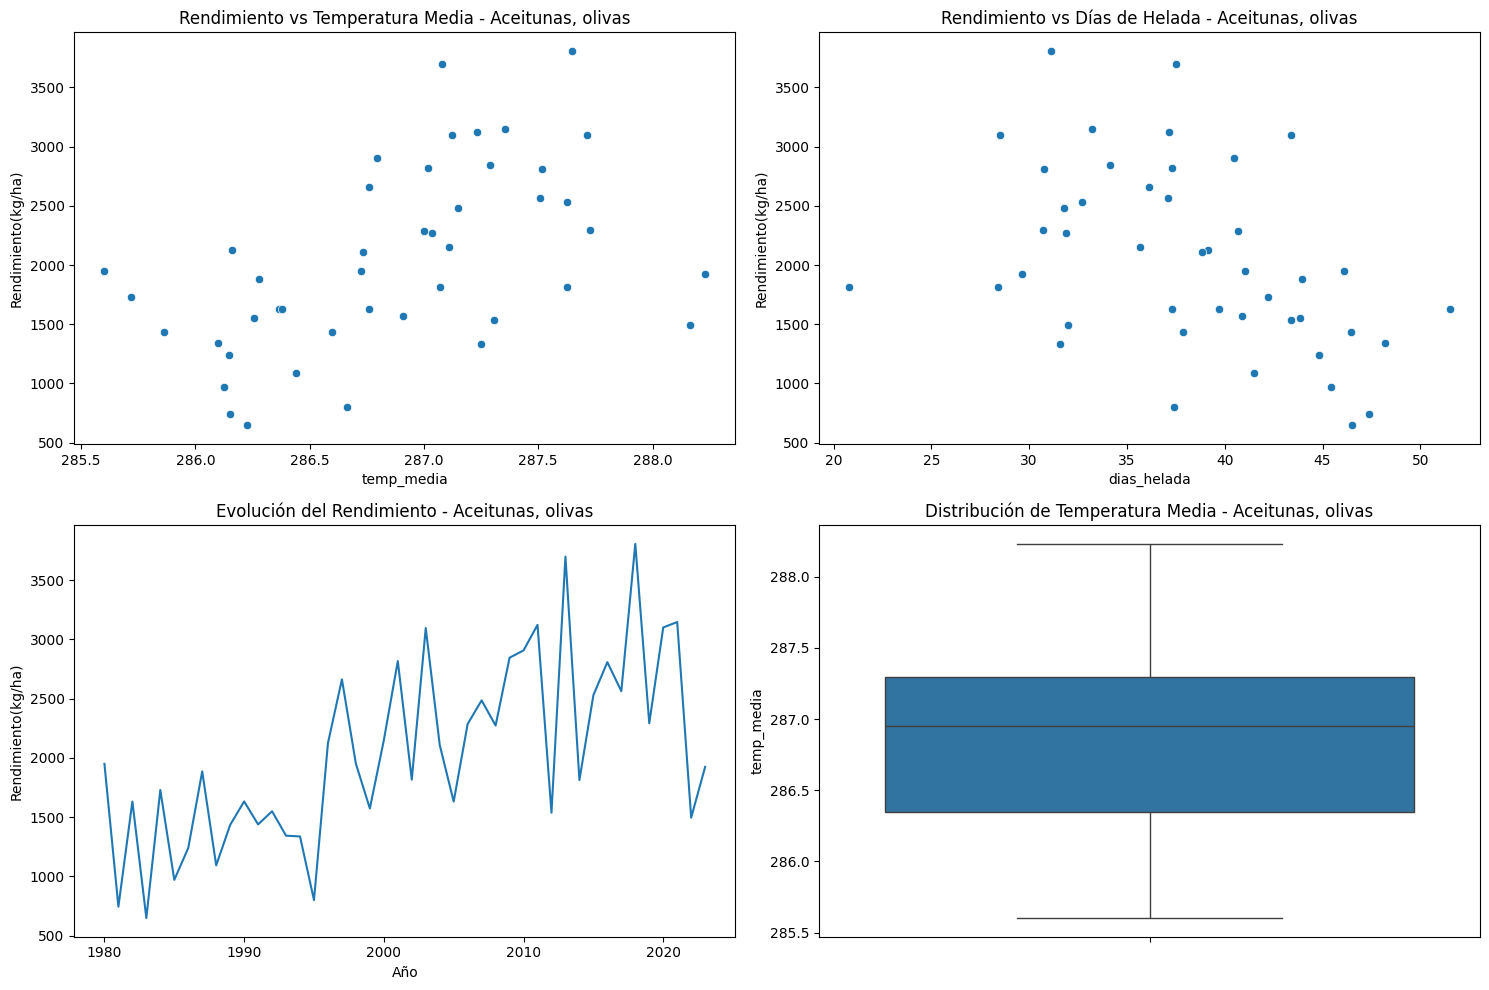

In [6]:
if __name__ == "__main__":
    df = main()

In [7]:
df.info(60)

<class 'pandas.core.frame.DataFrame'>
Index: 5657 entries, 1934 to 6083
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Código del producto (CPC)     5657 non-null   float64
 1   Producto                      5657 non-null   object 
 2   Código del año                5657 non-null   int64  
 3   Año                           5657 non-null   int64  
 4   Produccion(toneladas)         5657 non-null   float64
 5   Area_cosechada(ha)            5657 non-null   float64
 6   Rendimiento(kg/ha)            5657 non-null   float64
 7   temp_media                    5657 non-null   float64
 8   dias_calefaccion              5657 non-null   float64
 9   dias_refrigeracion            5657 non-null   float64
 10  dias_helada                   5657 non-null   float64
 11  temp_max                      5657 non-null   float64
 12  temp_max_media                5657 non-null   float64
 13  temp_

In [9]:
df.describe()

,Código del producto (CPC),Código del año,Año,Produccion(toneladas),Area_cosechada(ha),Rendimiento(kg/ha),temp_media,dias_calefaccion,dias_refrigeracion,dias_helada,...,rango_temp_media,temp_stress,helada_stress,temp_media_prev_year,dias_helada_prev_year,temp_max_prev_year,temp_min_prev_year,dias_calefaccion_prev_year,dias_refrigeracion_prev_year,rendimiento_prev_year
count,5657.000000,5657.000000,5657.000000,5.657000e+03,5.657000e+03,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,...,5657.000000,5657.0,5657.000000,5552.000000,5552.000000,5552.000000,5552.000000,5552.000000,5552.000000,5552.000000
mean,1278.087051,1992.678451,1992.678451,6.233138e+05,1.462463e+05,12610.338271,286.617200,1616.312039,227.868318,39.461454,...,7.378676,1.0,0.938130,286.590604,39.608580,305.441028,268.274761,1621.336424,225.574854,12579.447550
std,449.127798,17.735255,17.735255,1.488252e+06,4.979949e+05,15951.543652,0.673548,143.520751,58.388824,6.465503,...,0.341147,0.0,0.240941,0.649143,6.418421,1.164546,1.738557,139.513519,56.397274,15867.245686
min,111.000000,1961.000000,1961.000000,0.000000e+00,1.000000e+00,0.000000,285.602374,1293.143514,129.855910,20.804128,...,6.642418,1.0,0.000000,285.602374,20.804128,302.919235,263.417360,1293.143514,129.855910,0.000000
25%,1232.000000,1978.000000,1978.000000,1.142300e+04,2.500000e+03,1527.300000,286.100763,1505.329541,184.584255,35.328160,...,7.115642,1.0,1.000000,286.100763,35.328160,304.583552,267.237692,1505.845041,184.584255,1529.150000
50%,1330.000000,1993.000000,1993.000000,7.810000e+04,1.400000e+04,6479.600000,286.598662,1614.050366,214.348113,40.425359,...,7.362489,1.0,1.000000,286.598662,40.425359,305.407769,268.602021,1623.677878,212.047893,6506.950000
75%,1448.000000,2008.000000,2008.000000,4.074280e+05,4.502200e+04,17967.800000,287.121252,1730.599560,266.643607,43.947476,...,7.563985,1.0,1.000000,287.111337,43.947476,306.160055,269.531819,1730.599560,260.989059,17935.900000
max,1970.000000,2023.000000,2023.000000,1.207000e+07,4.412800e+06,102830.500000,288.230061,1856.501855,374.309391,51.516642,...,8.317057,1.0,1.000000,288.161939,51.516642,308.247371,271.791148,1856.501855,374.309391,102830.500000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5657 entries, 1934 to 6083
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Código del producto (CPC)     5657 non-null   float64
 1   Producto                      5657 non-null   object 
 2   Código del año                5657 non-null   int64  
 3   Año                           5657 non-null   int64  
 4   Produccion(toneladas)         5657 non-null   float64
 5   Area_cosechada(ha)            5657 non-null   float64
 6   Rendimiento(kg/ha)            5657 non-null   float64
 7   temp_media                    5657 non-null   float64
 8   dias_calefaccion              5657 non-null   float64
 9   dias_refrigeracion            5657 non-null   float64
 10  dias_helada                   5657 non-null   float64
 11  temp_max                      5657 non-null   float64
 12  temp_max_media                5657 non-null   float64
 13  temp_

In [8]:
#exportar el dataframe a un archivo csv
df.to_csv('datos_preparado.csv', index=False)